# Bayesian Statistical Inference: IV

*Davide Gerosa (Milano-Bicocca)* 

##### Reading:

- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 5.
- [MCMC Sampling](https://twiecki.io/blog/2015/11/10/mcmc-sampling) by Thomas Wiecki.
- [MCMC Interactive Demo](https://chi-feng.github.io/mcmc-demo/app.html) by Chi Feng.
- [Using Markov Chain Monte Carlo](https://arxiv.org/abs/1710.06068) by Hogg and Foreman-Mackey 


This course is based on previous work by many people. See [here]((https://github.com/dgerosa/astrostatistics_bicocca_2022/blob/main/README.md) for credits.


Make sure the python packages `emcee` and `pymc3` are installed. If you're running this notebook through binder, they should alread be there.

## Practical MCMC <a class="anchor" id="one"></a>

In [1]:
# Execute this cell
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from scipy import integrate
from scipy.stats import norm
from scipy.stats import cauchy
from astroML.plotting import hist
from astroML.plotting.mcmc import convert_to_stdev
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)
from astroML.plotting.mcmc import convert_to_stdev
import warnings; warnings.simplefilter('ignore')

### Practical MCMC chain checks

1. **CHECK ACCEPTANCE:** some MCMC samplers give an updating estimate of the current acceptance rate of new samples. Ideally for a sampler using some form of Metropolis-Hastings, this should be somewhere between $\sim20-50\%$ depending on the type of problem you're trying to solve.

    - If the acceptance rate is high, the chain is moving but might not be exploring well. This gives high acceptance rate but poor global exploration of the posterior surface.
    
    - If the acceptance rate is low, the chain is hardly moving meaning that it's stuck in a rut or trying to jump to new points that are too far away.
    

2. **CHECK TRACEPLOTS:** After getting an idea of the acceptance rate, make traceplots of your chain. Ideally, our traceplot in each parameter would be mixing well (moving across parameter space without getting stuck), and carving out the same patch of parameter space on average. This will tell you whether your chain is getting stuck or encountering inefficiencies.


3. **CHECK AUTOCORRELATION LENGTH:** The MCMC chain with Metropolis-Hastings will not give fully-independent random samples. The next point is influenced by where the previous point was. We need to check how much to down-sample the chain so that the points lack memory and influence from others. This is given by the ***autocorrelation length***. 

Check this out: [Roy (2019)](https://arxiv.org/abs/1909.11827)

For a discussion on the mathematical definition of the autocorrelation, I find the [emcee documentation](https://emcee.readthedocs.io/en/stable/tutorials/autocorr/) particularly clear. It is a concise version of [this paper](https://www.semanticscholar.org/paper/Monte-Carlo-Methods-in-Statistical-Mechanics%3A-and-Sokal/0bfe9e3db30605fe2d4d26e1a288a5e2997e7225?p2df).

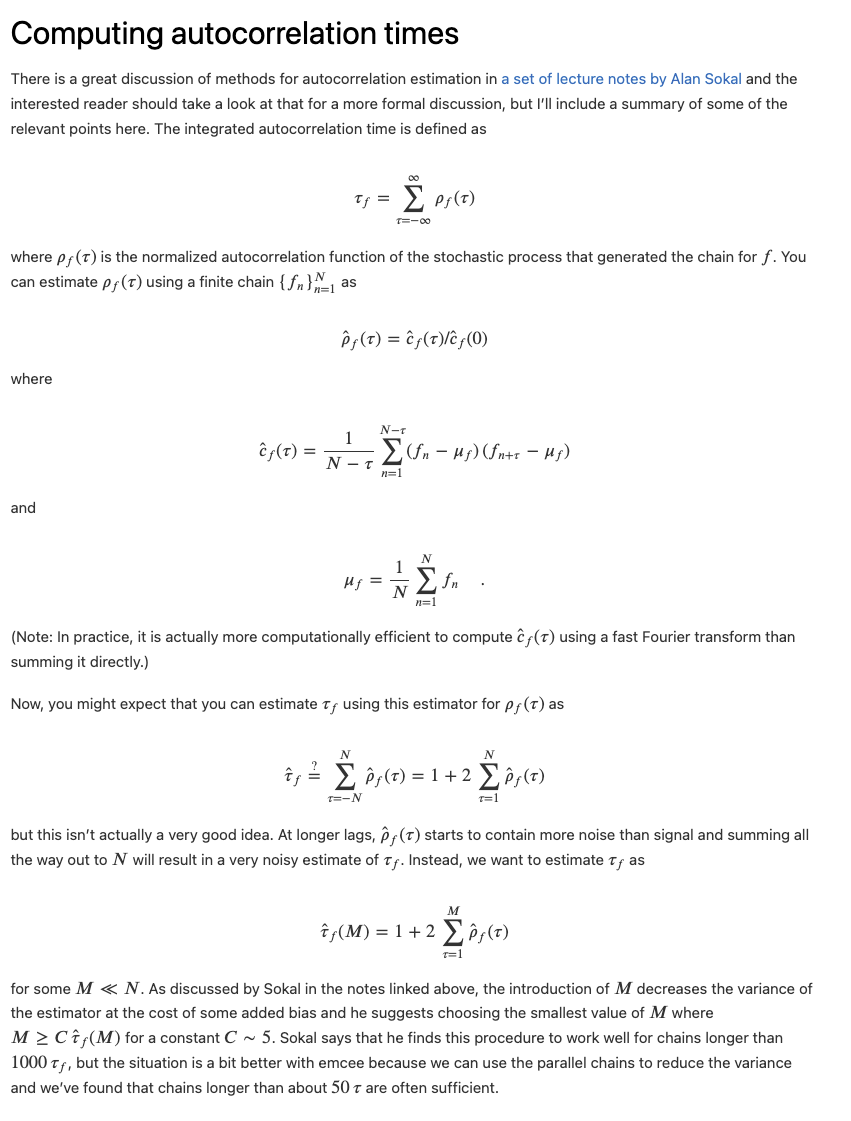

### Optimizing sampling

There are several ways of improving the way we propose new sample locations in Metropolis-Hastings. Here are a few.

#### (a) Adaptive Metropolis (AM)

In AM you use the **empirically-estimated parameter covariance matrix to tune the width of the Gaussian proposal  distribution**. Tuning is updated during the sampling in order to reach optimal mixing. In practice this  means  that  one  uses  the  entire  past  history  of  the  chain  up  until  the  current point to estimate the parameter covariance matrix, scaling this covariance matrix by $\alpha= 2.38^2/N_\mathrm{param}$ to reach the optimal $\sim25\%$ proposal acceptance rate. 

Practically speaking, the procedure is
- Estimate the $N_\mathrm{param}\times N_\mathrm{param}$ parameter covariance matrix, $C$, using all samples. Standard numpy or scipy algorithms can do this. 
- Factorize the matrix using a Cholesky algorithm, such that $C = L L^T$.
- Draw a new proposed point such that $y = x_i + \alpha Lu$, where $x_i$ is the current point, and $u$ is an $N_\mathrm{param}$-dimensional vector of random draws from a zero-mean unit-variance Gaussian.

*One subtlety here is that by using more than just the most recent point to tune the sampling, our chain is no longer Markovian. This is easily resolved by allowing the chain to pass through a proposal tuning stage using AM, after which the proposal covariance matrix is frozen so that the chain is Markovian then on.*

#### (b) Single Component Adaptive Metropolis (SCAM)

With high-dimensional model parameter spaces, or even target posterior distributions with significant covariances amongst some parameters, the AM method may suffer from low acceptance rates. One method that addresses this is a variant on AM called Single Component Adaptive Metropolis (SCAM).  **This  involves  jumping  along selected eigenvectors (or principal axes) of the parameter covariance matrix**, whichis equivalent to jumping in only one uncorrelated parameter at a time. (We'll see more of principal axes later in the course)

- We take our parameter covariance matrix as in AM, but this time work out the eigenvalues and eigenvectors, $C = D\Lambda D^T$, where $D$ is a unitary matrix with eigenvectors as columns, and $\Lambda = \mathrm{diag}(\sigma^2_\Lambda$) is a diagonal matrix of eigenvalues. 
- A SCAM jump corresponds to a zero-mean unit-variance jump in a randomly chosen uncorrelated parameter, equivalent to jumping along one of the eigenvectors. 
- A proposal draw is given by $y = x_i+ 2.4 D_j u_j$, where $D_j$ is a randomly chosen column of D corresponding to the $j$th eigenvector of $C$, and $u_j \sim \mathcal{N}(0,\sigma^j_\Lambda)$.

#### (c) Differential Evolution (DE)

Another popular proposal scheme is DE, which is a simple *genetic algorithm* that treats the past history of the  chain up until the current point as a population. 

- In DE, you choose two random points from the chain’s history to construct a difference vector along which the chain can jump. 
- A DE proposal draw is given by $y = x_i + \beta(x_{r1} − x_{r2})$, where $x_{r1,2}$ are parameter vectors from two randomly chosen points in the past history of the chain, and $\beta$ is a scaling factor that is usually set to be the same as the AM scaling factor, $\alpha = 2.4^2 / N_\mathrm{param}$.


#### The Full Proposal Cocktail

Real world MCMC should use a cocktail of proposal schemes, aimed at ensuring convergence to the target posterior distribution with **minimal burn-in**, **optimal acceptance rate**, and as **short an autocorrelation length** as possible. 

At each MCMC iteration the proposed parameter location can be drawn according to a weighted list of schemes, involving **(i) AM, (ii) SCAM, (iii) DE, (iv) empirical proposal distributions (e.g. from previous analyses), and finally (iv) draws from the parameter prior distribution**. 

The final prior-draw scheme allows for occasional large departures from regions of high likelihood, ensuring that we are exploring the full parameter landscape well, and avoiding the possibility of getting stuck in local maxima. 

Really, you can use any reasonable distribution you like to propose points. Your only constraint is to ensure that detailed balance is maintained through the relevant transition weightings in  the  Metropolis-Hastings ratio, $p_\mathrm{acc}$.

##  MCMC Parameter Estimation In The Wild <a class="anchor" id="two"></a>

Let's look at some more involved examples. We will use two popular python modules: `emcee` and `PyMC`. Another  great but less used sampler that is the standard one in gravitational-wave astrophysics: `PTMCMCSampler`. Quoting Jake VanderPlas for `emcee` and `PyMC`: 
[Jake's blog:](http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/)

### emcee

> The emcee package (*also known as MCMC Hammer, which is in the running for best Python package name in history*) is a Pure Python package written by Astronomer Dan Foreman-Mackey. It is a lightweight package which implements a fairly sophisticated Affine-invariant Hamiltonian MCMC. Because the package is pure Python (i.e. it contains no compiled extensions) it is extremely easy to install; with pip, simply type at the command-line "pip install emcee".

Emcee does not have much specific boilerplate code; it simply requires you to pass it a Python function which returns a value proportional to the log-posterior probability, and returns samples from that posterior.*

### PyMC

> The PyMC package has many more features than emcee, including built-in support for efficient sampling of common prior distributions. PyMC by default uses the classic Metropolis-Hastings sampler, one of the earliest MCMC algorithms. For performance, it uses compiled fortran libraries, so it is less trivial to install using tools like pip. PyMC binaries for many systems can be quite easily installed with conda.*

More details about PyMC are available from [the pyMC User Guide](https://pymc-devs.github.io/pymc/), but note that we are going to be using [PyMC3](https://docs.pymc.io/).

### PTMCMCSampler

> This is a bare-bones sampler, requiring only that the user provide a log-likelihood function and a log-prior function. The user can change the relative amounts of AM, SCAM, and DE being used to propose new points to jump to. The great thing about this sampler is that one can add new custom proposal schemes according to the user's preference. 

> Also, this sampler implements **parallel tempering MCMC (PTMCMC)**. We won't go into detail about this, but suffice it to say that multiple copies of the MCMC are run in parallel, where the copies actually sample from different roots of the likelihood. The higher roots we take, the more the likelihood is flattened out, making it easier to sample. These "rooted" chains then communicate back to the main chain, improving exploration of the parameter space. All these chains can actually be post-processed to get the Bayesian evidence too, in a scheme called **thermodynamic integration**.

##  MCMC with emcee <a class="anchor" id="three"></a>

Import `emcee` and generate some homoescedastic Gaussian data. We'll assume the standard deviation is know, so we're only estimating $\mu$.

In [7]:
import emcee

np.random.seed(21)
Ndata = 100
mu = 1.0
sigma = 0.5 # assumed known 
data = stats.norm(mu, sigma).rvs(Ndata)

Define all the relevant functions.

In [8]:
def Likelihood(x, sigma, data):
    # Gaussian likelihood 
    return np.prod(np.exp(-(data-x)**2 /2 /sigma**2))

def Prior(x):
    return 1.0 / 10   # flat: it cancels out and has no effect 

def myPosterior(x, sigma, data):
    return Likelihood(x, sigma, data) * Prior(x)

# emcee wants ln of posterior pdf
def myLogPosterior(x, sigma, data):
    return np.log(myPosterior(x, sigma, data))

`emcee` combines multiple "walkers", each of which is its own MCMC chain. The number of trace results will be nwalkers $\times$ nsteps.

In [9]:
ndim = 1  # number of parameters in the model
nwalkers = 6  # number of MCMC walkers
burn = 1000  # "burn-in" period to let chains stabilize
nsteps = 5000  # number of MCMC steps to take **for each walker**

# initialize theta 
np.random.seed(0)
starting_guesses = np.random.random((nwalkers, ndim))

# the function call where all the work happens: 
sampler = emcee.EnsembleSampler(nwalkers, ndim, myLogPosterior, args=[sigma, data])
sampler.run_mcmc(starting_guesses, nsteps)
 
# sampler.chain is of shape (nwalkers, nsteps, ndim)
# throw-out the burn-in points and reshape:
emcee_trace  = sampler.chain[:, burn:, :].reshape(-1, ndim)

print("done")

done


In [10]:
print(sampler.chain.shape) #original chain structure
print(emcee_trace.shape) #burned and flattened chain

(6, 5000, 1)
(24000, 1)


Text(0.5, 1.0, 'Chain from emcee')

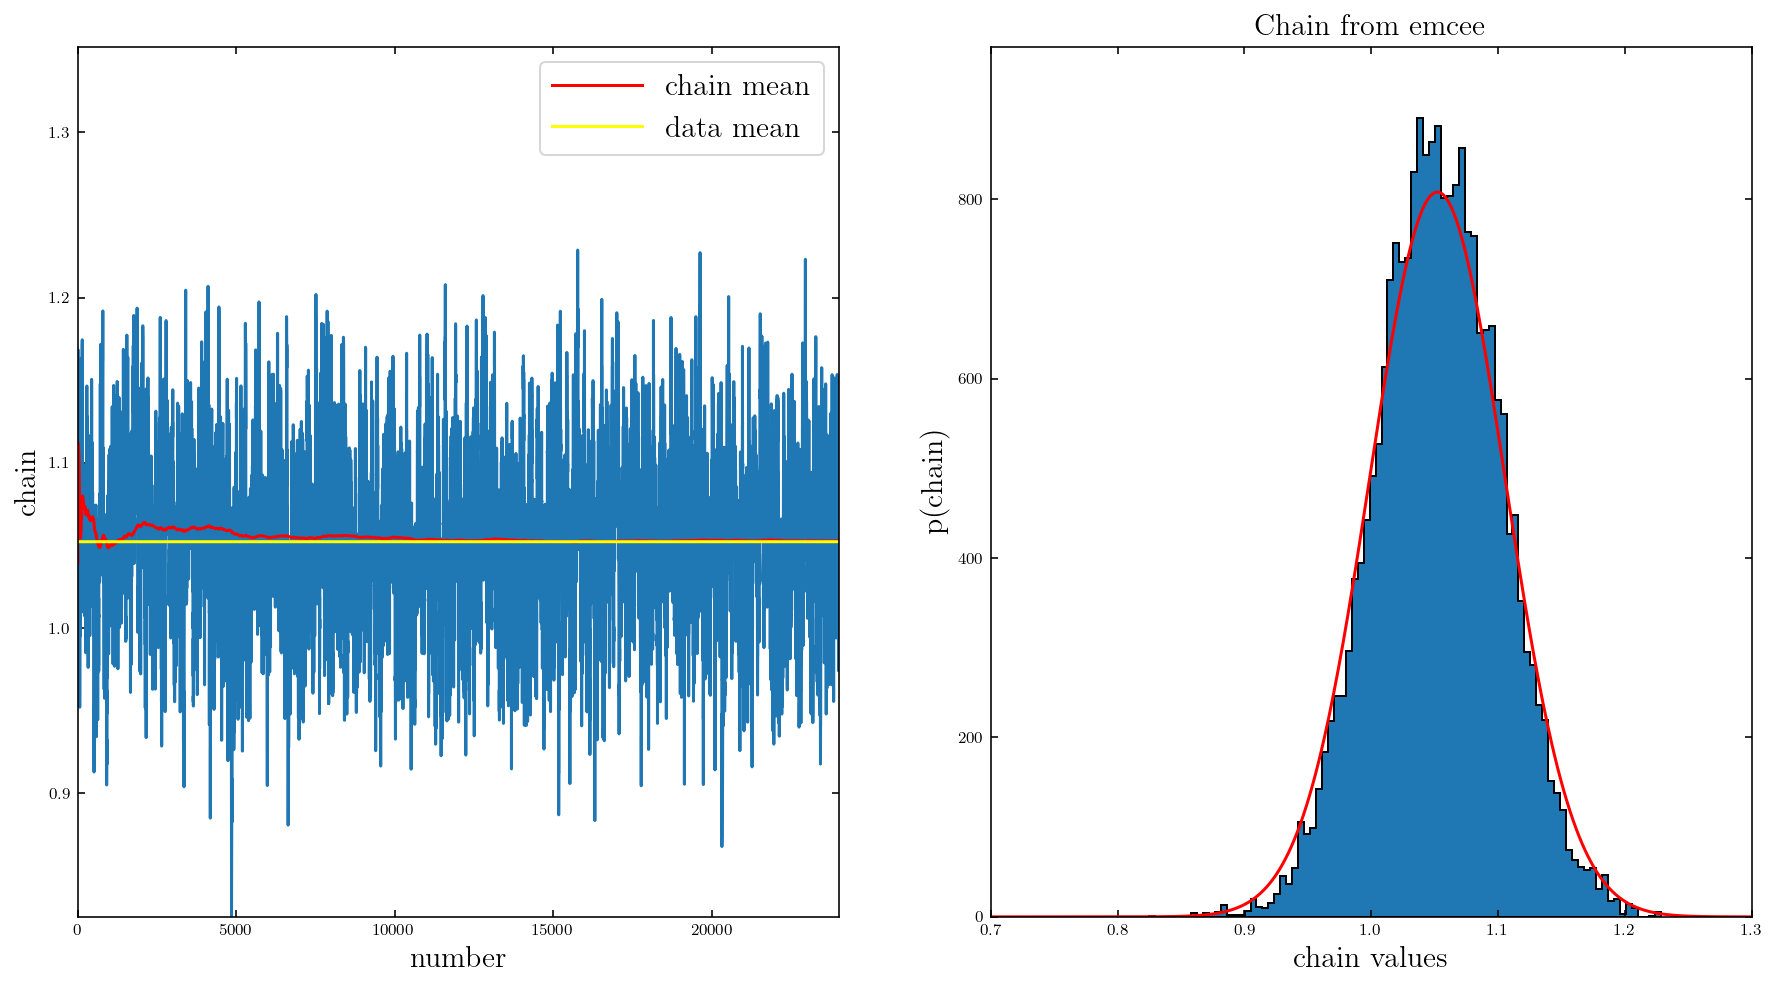

In [11]:
# plot 
plt.rcParams.update({'font.size': 22})

fig = plt.figure(figsize=(15, 8))
#fig.subplots_adjust(left=0.11, right=0.95, 
                   # wspace=0.35, bottom=0.18)

chainE = emcee_trace #[0]
M = np.size(chainE)

ax1 = fig.add_subplot(121)
xgrid = np.linspace(1, M, M)
plt.plot(xgrid, chainE)
ax1.axis([0, M, np.min(chainE), 1.1*np.max(chainE)])
plt.xlabel('number',fontsize=15)
plt.ylabel('chain',fontsize=15)

# plot running mean: 
meanC = [np.mean(chainE[:int(N)]) for N in xgrid]
ax1.plot(xgrid, meanC, c='red', label='chain mean') 
ax1.plot(xgrid, 0*xgrid + np.mean(data),
         c='yellow',label='data mean')
ax1.legend(fontsize=15)

ax2 = fig.add_subplot(122)
# skip first burn samples
Nburn = 1000
Nchain = np.size(chainE[xgrid>burn])
Nhist, bins, patches = plt.hist(chainE[xgrid>Nburn], 
                                bins='auto', histtype='stepfilled')

# plot expectations based on central limit theorem
binwidth = bins[1] - bins[0]
muCLT = np.mean(data)
sigCLT = np.std(data)/np.sqrt(Ndata)
muGrid = np.linspace(0.7, 1.3, 500)
gauss = Nchain * binwidth * stats.norm(muCLT, sigCLT).pdf(muGrid) 
ax2.plot(muGrid, gauss, c='red') 

ax2.set_ylabel('p(chain)',fontsize=15)
ax2.set_xlabel('chain values',fontsize=15)
ax2.set_xlim(0.7, 1.3)
ax2.set_ylim(0, 1.2*np.max(gauss))
ax2.set_title(r'Chain from emcee',fontsize=15)

##  MCMC with PyMC3 <a class="anchor" id="four"></a>

Now we will use pyMC3 to get a 2-dimensional posterior pdf for location and scale parameters using a sample drawn from a **Cauchy distribution**. Remember a Cauchy distribution formally has no mean or standard deviation because its tails fall off shallower than $1/x^2$.

The following is code adapted from Figure 5.22 of the textbook. Initially, we load in `PyMC3` and define the Cauchy log likelihood. 

***NOTE:*** The code here for the Cauchy likelihood is actually only for when we look at the analytic estimate, since `PyMC3` has ready-made modules for many standard functions!

In [12]:
from scipy.stats import cauchy
import pymc3 as pm

if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

def cauchy_logL(xi, sigma, mu):
    """Equation 5.74: cauchy likelihood"""
    xi = np.asarray(xi)
    n = xi.size
    shape = np.broadcast(sigma, mu).shape

    xi = xi.reshape(xi.shape + tuple([1 for s in shape]))

    return ((n - 1) * np.log(sigma)
            - np.sum(np.log(sigma ** 2 + (xi - mu) ** 2), 0))

Generate some data from the Cauchy distribution.

In [13]:
# ----------------------------------------------------------------------
# Draw the sample from a Cauchy distribution
np.random.seed(44)
mu_0 = 0
gamma_0 = 2
xi = cauchy(mu_0, gamma_0).rvs(10)

Set up the `PyMC3` model.

In [14]:
# ----------------------------------------------------------------------
# Set up and run MCMC:
with pm.Model():
    mu = pm.Uniform('mu', -5, 5) #uniform in Cauchy mu
    log_gamma = pm.Uniform('log_gamma', -10, 10) #uniform in log of Cauchy gamma

    # set up our observed variable x
    # i.e. read this as 'x is distributed as a Cauchy variable'
    x = pm.Cauchy('x', mu, np.exp(log_gamma), observed=xi)

    trace = pm.sample(draws=12000, tune=1000, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [log_gamma, mu]


Sampling 2 chains for 1_000 tune and 12_000 draw iterations (2_000 + 24_000 draws total) took 14 seconds.


You may have seen some output messages along the lines of "Auto-assigning NUTS sampler...". `PyMC3` is very sophisticated, and will automatically decide for you the best tools for the job. 

In this case, it decided you needed **No-U-Turn Hamiltonian gradient-based sampling**, where gradient information about the Cauchy likelihood helped in the exploration of parameter space. 

In [15]:
# compute histogram of results to plot below
L_MCMC, mu_bins, gamma_bins = np.histogram2d(trace['mu'],
                                             np.exp(trace['log_gamma']),
                                             bins=(np.linspace(-5, 5, 41),
                                                   np.linspace(0, 5, 41)))
L_MCMC[L_MCMC == 0] = 1E-16  # prevents zero-division errors

# ----------------------------------------------------------------------
# Compute likelihood analytically for comparison
mu = np.linspace(-5, 5, 70)
gamma = np.linspace(0.1, 5, 70)
logL = cauchy_logL(xi, gamma[:, np.newaxis], mu)
logL -= logL.max()

p_mu = np.exp(logL).sum(0)
p_mu /= p_mu.sum() * (mu[1] - mu[0])

p_gamma = np.exp(logL).sum(1)
p_gamma /= p_gamma.sum() * (gamma[1] - gamma[0])

hist_mu, bins_mu = np.histogram(trace['mu'], bins=mu_bins, density=True)
hist_gamma, bins_gamma = np.histogram(np.exp(trace['log_gamma']),
                                      bins=gamma_bins, density=True)

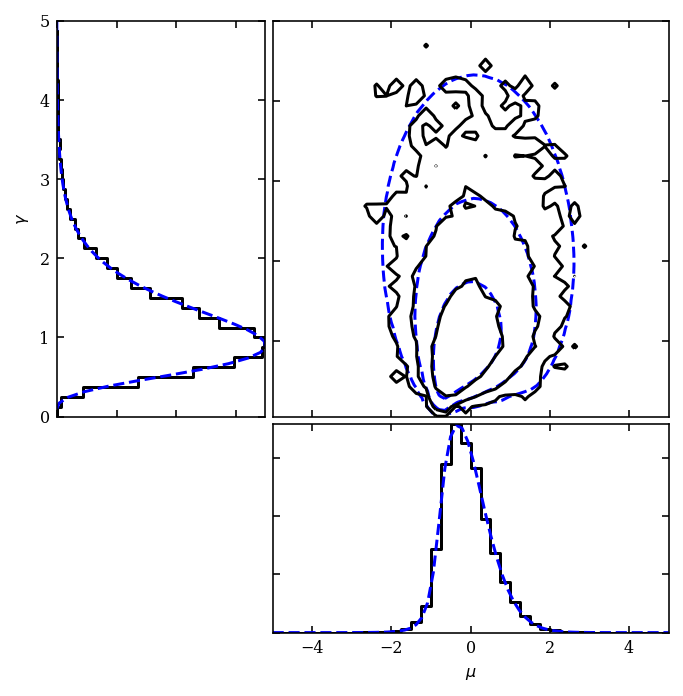

In [16]:
# ----------------------------------------------------------------------
# plot all the results
fig = plt.figure(figsize=(5, 5))

# first axis: likelihood contours
ax1 = fig.add_axes((0.4, 0.4, 0.55, 0.55))
ax1.xaxis.set_major_formatter(plt.NullFormatter())
ax1.yaxis.set_major_formatter(plt.NullFormatter())

ax1.contour(mu, gamma, convert_to_stdev(logL),
            levels=(0.683, 0.955, 0.997),
            colors='b', linestyles='dashed')

ax1.contour(0.5 * (mu_bins[:-1] + mu_bins[1:]),
            0.5 * (gamma_bins[:-1] + gamma_bins[1:]),
            convert_to_stdev(np.log(L_MCMC.T)),
            levels=(0.683, 0.955, 0.997),
            colors='k')

# second axis: marginalized over mu
ax2 = fig.add_axes((0.1, 0.4, 0.29, 0.55))
ax2.xaxis.set_major_formatter(plt.NullFormatter())
ax2.plot(hist_gamma, 0.5 * (bins_gamma[1:] + bins_gamma[:-1]
                            - bins_gamma[1] + bins_gamma[0]),
         '-k', drawstyle='steps')
ax2.plot(p_gamma, gamma, '--b')
ax2.set_ylabel(r'$\gamma$')
ax2.set_ylim(0, 5)

# third axis: marginalized over gamma
ax3 = fig.add_axes((0.4, 0.1, 0.55, 0.29))
ax3.yaxis.set_major_formatter(plt.NullFormatter())
ax3.plot(0.5 * (bins_mu[1:] + bins_mu[:-1]), hist_mu,
         '-k', drawstyle='steps-mid')
ax3.plot(mu, p_mu, '--b')
ax3.set_xlabel(r'$\mu$')
plt.xlim(-5, 5)

plt.show()

The resulting $2$D joint posterior pdf corner plot shows analytic results as blue dashed lines, and MCMC sampling results as black contours.

## Gibbs Sampling <a class="anchor" id="one"></a>

**Gibbs sampling** is an MCMC method that avoids acceptance-rejection techniques. Instead, one sweeps through each parameter (or block of parameters) to draw from their ***conditional probability distributions***, with all other parameters fixed to their current values. 

After sampling for a sufficiently large number of Gibbs steps, the principles of MCMC guarantee that **this process of sequential conditional probability drawing will converge to the joint posterior distribution of the overall model parameter space**. A standard Gibbs algorithm is shown below.

---
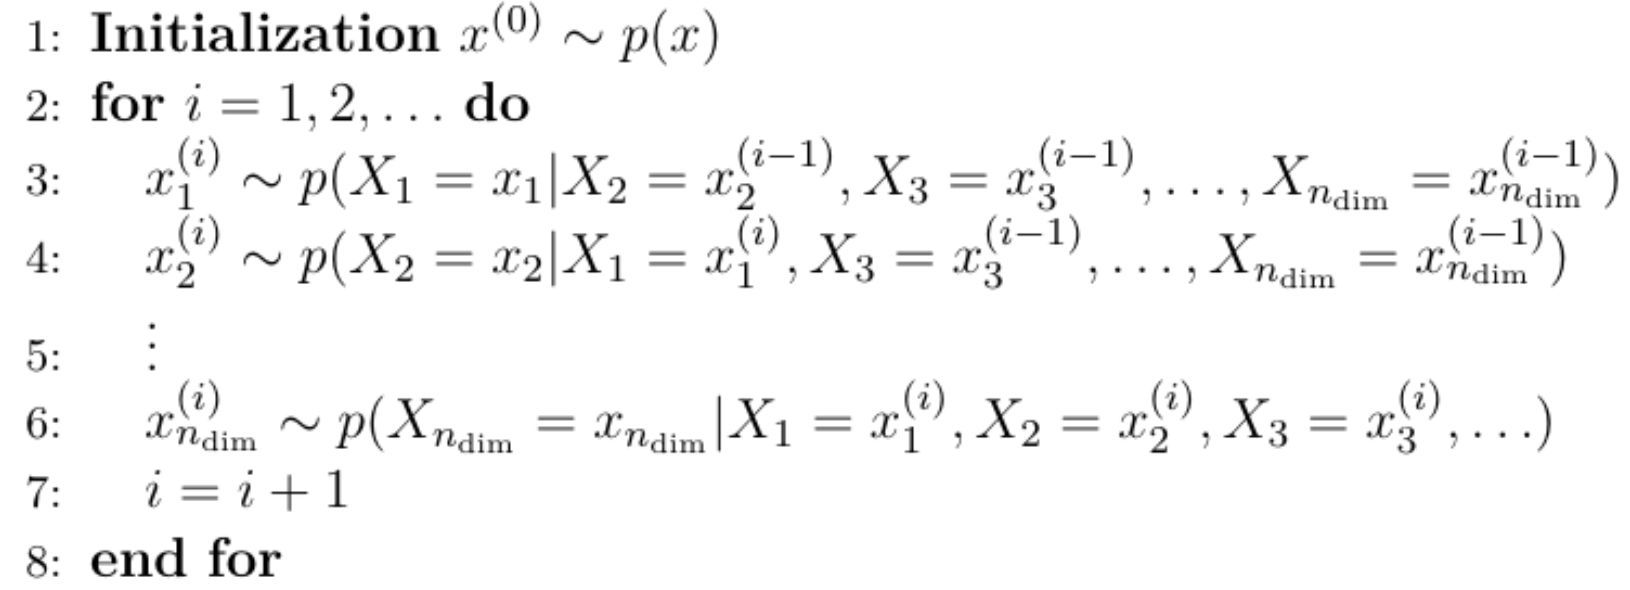

---

To break this algorithm up into words, we

- We initialize the sampler at some random point in parameter space.


- Fix all parameters except the first one. Draw a random value from the conditional posterior probability distribution of this first parameter **given** the fixed values of all other parameters.


- Fix all parameters except the second one. Draw a random value from the conditional posterior probability distribution of this second parameter **given** the fixed values of all other parameters **and the updated value of the first parameter**.


- *et cetera* for all parameters.


- Repeat for many Gibbs steps.



### Benefits of Gibbs Sampling <a class="anchor" id="onea"></a>

- By drawing directly from the posterior conditionals, the **auto-correlation length can be exceptionally small**, with **minimal burn-in**. 
- **It's also fast**; sequential draws directly from the parameter posterior conditionals means that we are not rejecting any points. 

### Drawbacks of Gibbs Sampling <a class="anchor" id="oneb"></a>

- You need to know the form of the conditional probability distributions for each parameter (or parameter blocks), and how to draw samples from it. 
- This can be a non-trivial problem, so typically a lot of effort is placed in manipulating the form of the posterior to find a conditional that is a standard probability distribution. This is where **conjugate priors** become really handy. 

### Conjugate Priors (Again) <a class="anchor" id="onec"></a>

> *These are parameter priors for which the the posterior lies in the same family of distributions as the prior.* 

***EXAMPLE***

- Imagine we have a Gaussian likelihood function with mean $\mu$ and variance $\sigma^2$ parameters. 
- The conjugate prior on $\mu$ when $\sigma^2$ is known (as is assumed in Gibbs when sweeping through each parameter) is a Gaussian distribution.
- Thus the conditional posterior distribution on $\mu$ is simply a Gaussian. 
- Similarly, the conjugate prior on $\sigma^2$ when $\mu$ is an inverse gamma distribution.
- Thus the conditional posterior distribution on $\sigma^2$ is an inverse gamma distribution.


Let's look at a speciifc example. We're going to analyze a homoescedastic Gaussian dataset. This is something we've done analytically in previous lectures but, crucially, this time search over the mean and standard deviation with MCMCs.

In [145]:
# Execute this cell
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from scipy import integrate
from scipy.stats import norm
from astroML.plotting import hist
from astroML.plotting.mcmc import convert_to_stdev
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)
from astroML.plotting.mcmc import convert_to_stdev
import warnings; warnings.simplefilter('ignore')
import corner
import emcee
import time

In [133]:
np.random.seed(21)
Ndata = 200
mu = 1.0
sigma = 1.0
data = stats.norm(mu, sigma).rvs(Ndata)

#### Metropolis-Hastings Approach

Quick implementation with Metropolis-Hastings, using emcee here

In [126]:
def logLikelihood(x):
    # Gaussian likelihood 
    return np.sum(stats.norm(loc=x[0], scale=x[1]).logpdf(data))

def Prior(x):
    # create a uniform prior in mu and sigma
    prior_mu = stats.uniform.pdf(x[0], loc=0.5, scale=1.0)
    prior_sigma = stats.uniform.pdf(x[1], loc=0.5, scale=1.0)
    return  prior_mu * prior_sigma


def logPosterior(x):
    
    lp =  np.log(Prior(x))
    if not np.isfinite(lp):
        return -np.inf
    else:
        return logLikelihood(x) + lp

###############


ndim = 2  # number of parameters in the model
nwalkers = 5  # number of MCMC walkers
nsteps = 5000  # number of MCMC steps to take **for each walker**

# initialize theta 
np.random.seed(0)
starting_guesses = np.array([1,1])+1e-3*np.random.randn(nwalkers, ndim)

In [146]:
# the function call where all the work happens: 
sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior)

elapsed=time.time()
sampler.run_mcmc(starting_guesses, nsteps)
print(time.time()-elapsed)

23.524380922317505


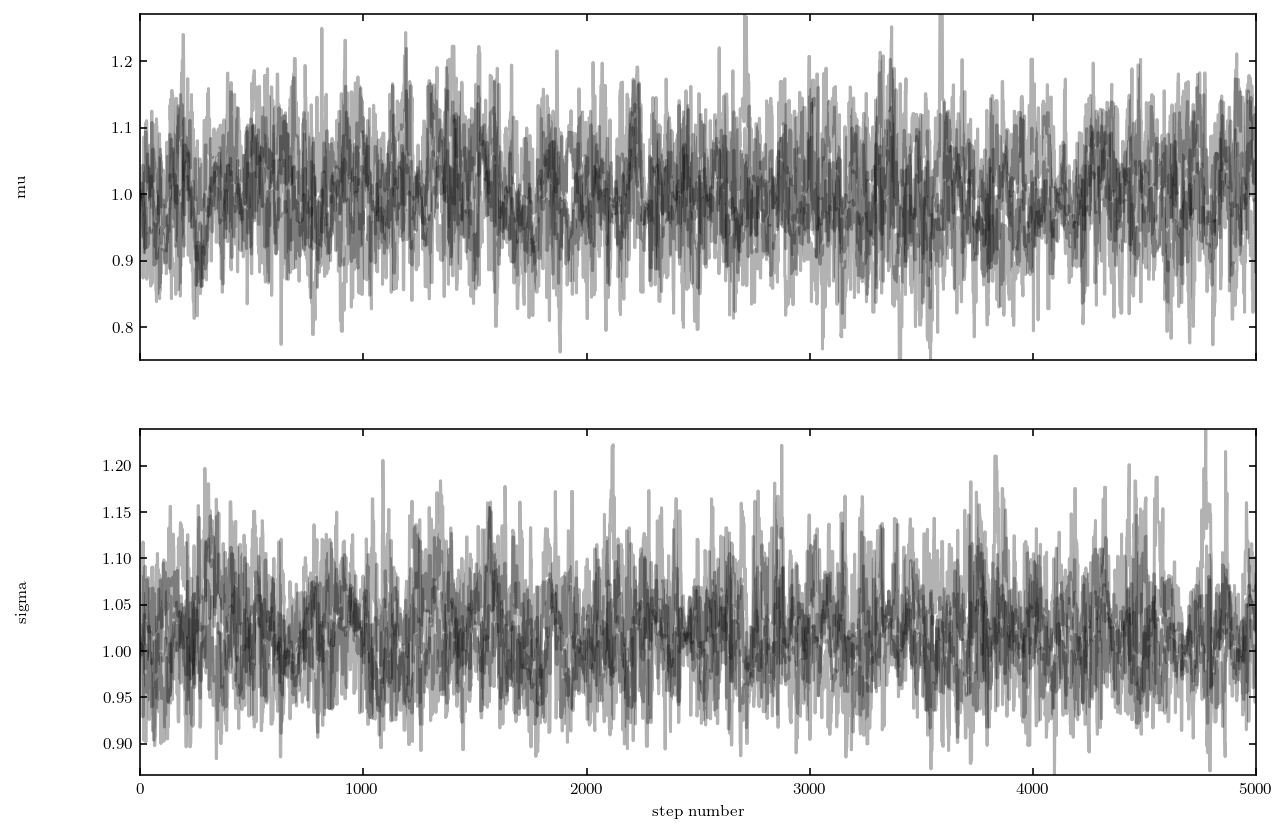

In [147]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["mu","sigma"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [148]:
tau = sampler.get_autocorr_time()
print(tau)

[36.42791996 36.39596761]


In [149]:
flat_samples = sampler.get_chain(discard=100, thin=30, flat=True)
print(flat_samples.shape)

(815, 2)


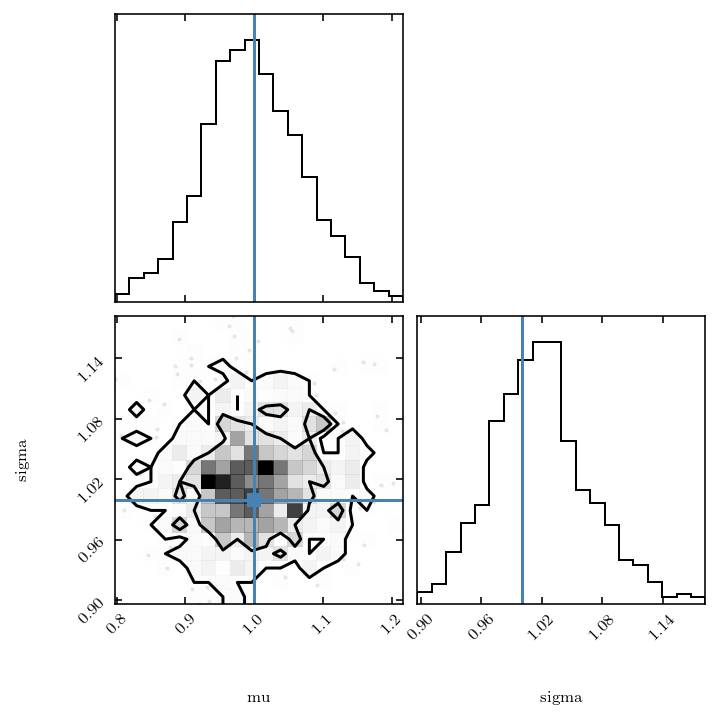

In [150]:
fig = corner.corner(
    flat_samples, labels=labels, levels=[0.68,0.95],truths=[1,1]
);

**On my machine it took about 25 seconds. After burning and thinning, I got $815$ samples**

#### Gibbs Approach

Code for this example is adapted from 
- https://wiseodd.github.io/techblog/2015/10/09/gibbs-sampling/
- https://bookdown.org/rdpeng/advstatcomp/gibbs-sampler.html
- https://www.wikiwand.com/en/Conjugate_prior. 

---

To make the Gibbs approach work, we need the conjugate priors for the mean and variance of a Gaussian likelihood. These are a Gaussian for the mean, and an inverse Gamma for the variance. We'll make these broad so that our posterior constraints are data-dominated.

$$ p(\mu) = \mathcal{N}(\mu_0,\sigma_0) = \frac{1}{\sqrt{2\pi\sigma_0^2}}\exp\left(\frac{-\mu^2}{2\sigma_0^2} \right)$$

where $\mu_0,\sigma_0$ are the location and scale parameters of the Gaussian prior on $\mu$, and 

$$ p(\sigma^2) = \mathrm{IG}(\alpha,\beta) = \frac{\beta^\alpha}{\Gamma(\alpha)} (1/\sigma^2)^{\alpha+1}\exp(-\beta/\sigma^2)$$

where $\alpha,\beta$ are parameters defining the shape of the inverse Gamma prior on $\sigma^2$.

It is algebraically tedious and relatively straightforward to multiply the Gaussian likelihood of the data with each of these priors in turn to work out the posterior conditional distributions on $\mu$ and $\sigma^2$. These turn out to be

$$ p(\mu|\{x_i\}) = \mathcal{N}(\mu_*,\sigma_*)$$

where 

$$\mu_* = \left( \frac{1}{\sigma_0^2} + \frac{n}{\sigma^2}\right)^{-1} \left(\frac{\mu_0}{\sigma_0^2} + \frac{\sum^n_{i=1}x_i}{\sigma^2} \right)$$

$$\sigma^2_* = \left( \frac{1}{\sigma_0^2} + \frac{n}{\sigma^2}\right)^{-1} $$

and 

$$ p(\sigma^2|\{x_i\}) = \mathrm{IG}(\alpha_*,\beta_*)$$

where 

$$ \alpha_* = \alpha + n/2$$

$$ \beta_* = \beta + \frac{\sum^n_{i=1}(x_i-\mu)^2}{2}$$

In [191]:
# conditional of \mu
def p_mu_given_sigma2(sigma2, x, mu0, sigma0):
    sigma_star2 = 1.0 / ( (1.0 / sigma0**2.) + (x.shape[0] / sigma2) )
    mu_star = sigma_star2 * ((mu0/sigma0**2.) + (np.sum(x)/sigma2))
    return np.random.normal(loc=mu_star, scale=np.sqrt(sigma_star2))

# conditional of \sigma^2
def p_sigma2_given_mu(mu, x, alpha, beta):
    alpha_star = alpha + x.shape[0]/2.
    beta_star = beta + np.sum((x-mu)**2.)/2.
    return stats.invgamma.rvs(a=alpha_star, scale=beta_star)


def gibbs_sampling(data, mu_initial, sigma2_initial,
                   mu0, sigma0, alpha, beta, iter=2000):
    samples = np.zeros((iter, 2))
    samples[0,:] = [mu_initial, sigma2_initial]

    for ii in range(1,iter):
        # sequential sampling of posterior conditionals
        ### mu first
        mu_new = p_mu_given_sigma2(samples[ii-1,1], data, mu0, sigma0)
        samples[ii,0] = mu_new
        ### then sigma2
        sigma2_new = p_sigma2_given_mu(samples[ii,0], data, alpha, beta)
        samples[ii,1] = sigma2_new

    return samples

In [205]:
# starting point
mu_initial = 0.2
sigma2_initial = 0.6

# priors
mu0 = 1.0
sigma0 = 0.9
alpha = 1.0
beta = 1.0

## SAMPLE!
def run_gibbs():
    samples = gibbs_sampling(data, mu_initial, sigma2_initial, 
                             mu0, sigma0, alpha, beta)
    return samples

In [206]:
samples = run_gibbs()

In [17]:
thin = int(emcee.autocorr.integrated_time(samples))
print('Taking every n = ' + str(thin)+1 + ' samples based on ac length.')
print('Burning first n = ' + str(500) + ' samples.')

plt.plot(samples[500::thin,0]); # burned and thinned mean
plt.plot(samples[500::thin,1]**0.5); # burned and thinned sigma

# injected values
plt.hlines(1.0, 0.0, 1500, color='k', lw=2, ls='dashed');
plt.hlines(0.5, 0.0, 1500, color='k', lw=2, ls='dashed');

NameError: name 'samples' is not defined

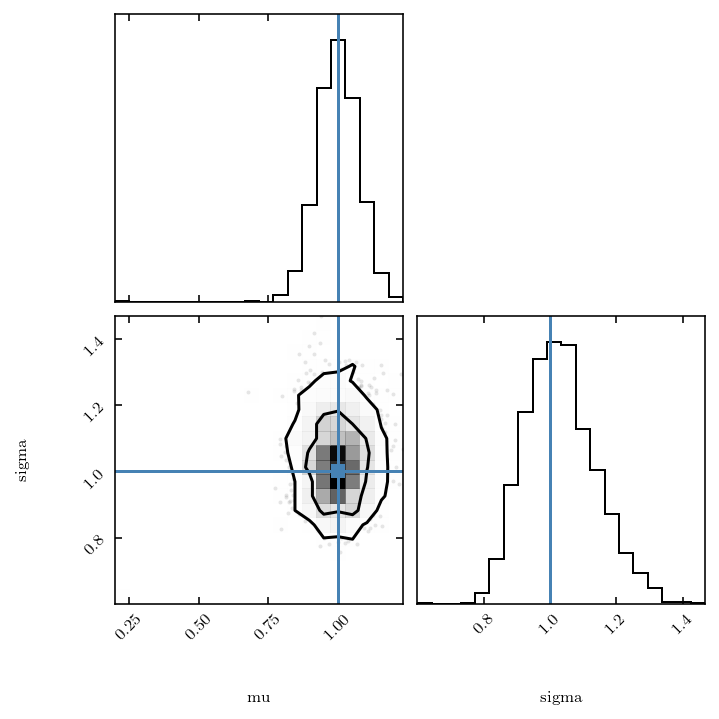

In [211]:
fig = corner.corner(
    samples, labels=labels, levels=[0.68,0.95],truths=[1,1]
);

Run the following code to time the Gibbs sampling of $2000$ posterior draws. No points are rejected. You'll see that this is about **two orders of magnitude faster than Metropolis-Hastings**, while also giving a greater number of sampled values.

In [209]:
%timeit -n1 run_gibbs()

156 ms ± 7.84 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Gibbs sampling is awesome...provided that you can work out the analytic conditional posteriors as standard distribution forms.** 

But even if you can't, all is not lost. You can get inventive by embedding a short Metropolis-Hastings block within the Gibbs algorithm. For example, if there are parameters for which you can not directly draw from the conditional, then your Gibbs step for that parameter could be a short Metropolis-Hastings MCMC run. 

The goal is to run this sufficiently long enough that you have drawn a single quasi-independent random sample from the parameter posterior conditional distribution, with all other parameters fixed. You can then proceed through the remainder of your Gibbs steps as normal. 

## Time to get your hands dirty.  The transient Universe

Time-domain astronomy is one of the new frontiers of the field. Example of transient phenomena include:

1. Tidal distruption events. [Stars shouldn't go near supermassive black holes, it's dangerous!]

Figure from Gezari (2021) ["Tidal Disruption Events", review](https://arxiv.org/abs/2104.14580)

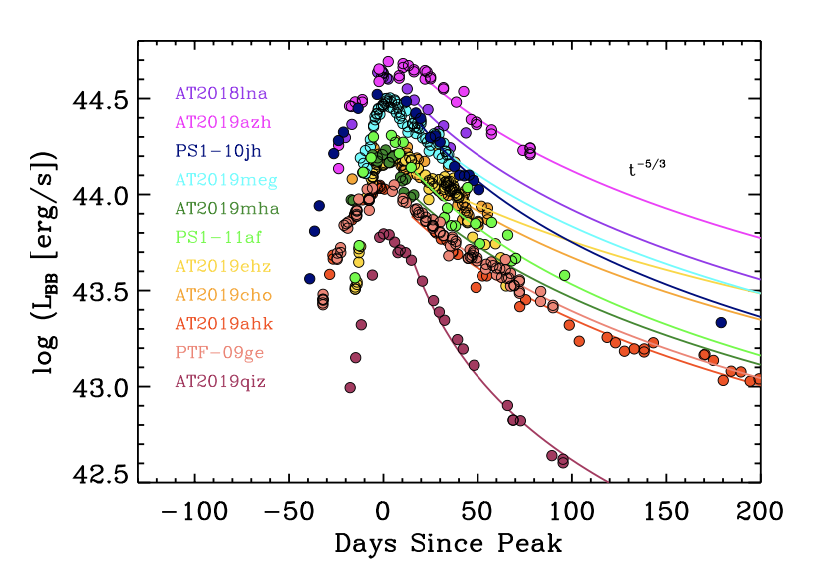

2. Sudden flares of active galactic nuclei

Figure from  Graham et al (2021) ["A Candidate Electromagnetic Counterpart to the Binary Black Hole Merger Gravitational Wave Event S190521ga"](https://arxiv.org/abs/2006.14122)

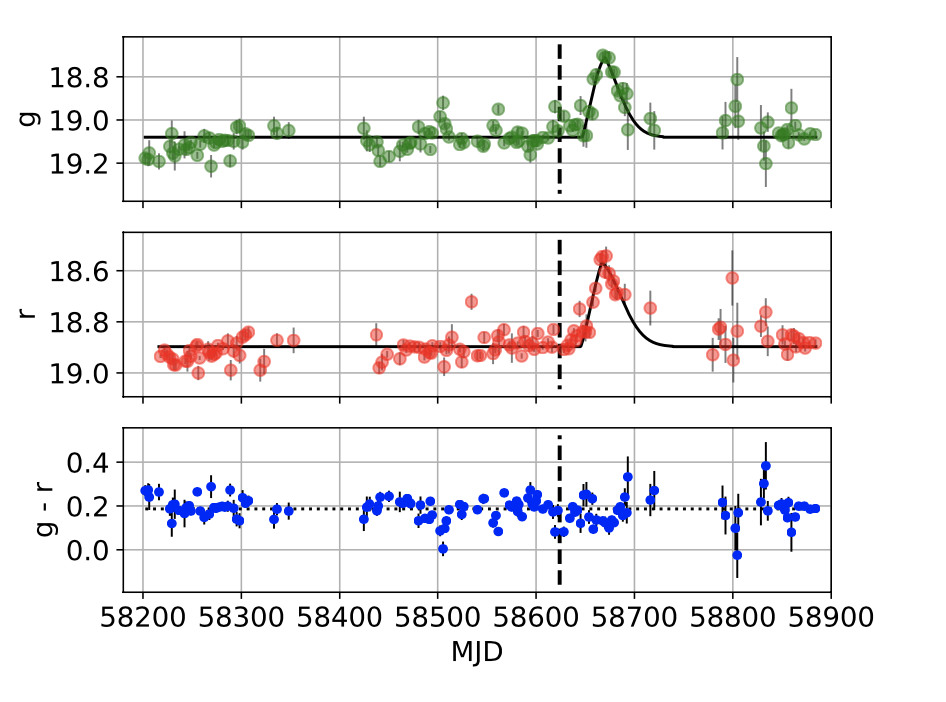

3. Supernovae.

Figure from  Jha et al (2019) ["Observational Properties of Thermonuclear Supernovae
"](https://arxiv.org/abs/1908.02303)

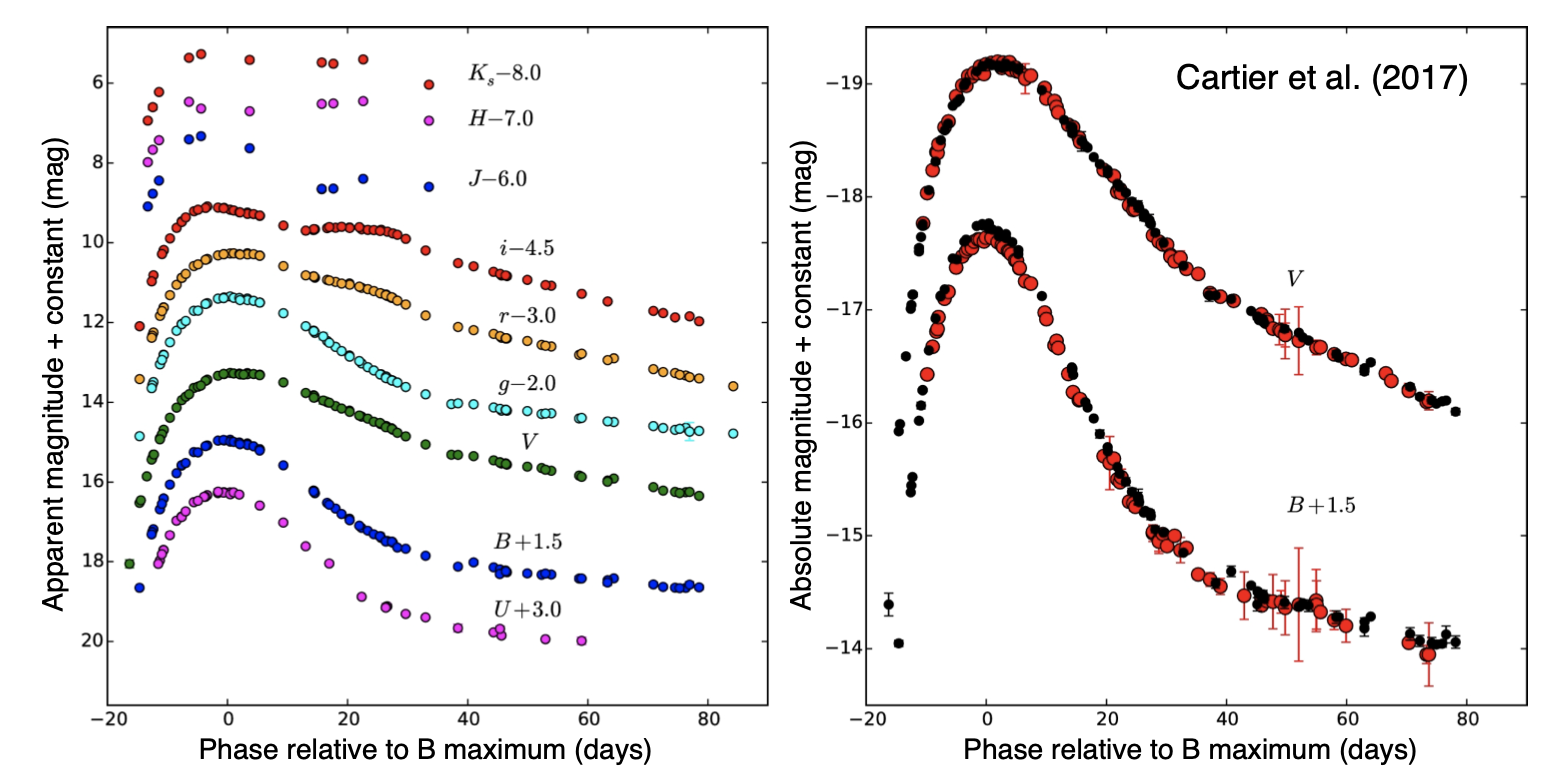


### Tasks

**Remember this is a real research example, not an exam! You're welcome (and encouraged actually!) to use all the tutorials/answers/hack you find online!***


1) Read in `solutions/transient.npy`. This is a (10 x 3) numpy array, containing some time-series measurements from a transient phenomenon. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC sampler that we looked at in class (`emcee`, `pymc3`), perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) For each parameter, find the median and 90% credible region of the marginalized distribution and quote results as, for instance, $t_0=X^{+Y}_{-Z}$ 



[My solution](https://github.com/dgerosa/astrostatistics_bicocca_2022/blob/main/solutions/S09_transient1.ipynb) 